# MNIST with CNN

In [3]:
#load everything
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## 1. ETL: Load the MNIST

In [4]:
transform = transforms.ToTensor()
#you guys need to me after this guy, the value becomes what??
#value will be normalized to [0, 1] and also converts to tensor

In [5]:
train_data = datasets.MNIST(root="../data", train=True, 
                            download=True, transform=transform)
#split the train into train and val
#this time, Chaky won't be lazy, he will create validation set, which everyone MUST
len(train_data)

60000

In [7]:
train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])
len(train_set), len(val_set)

(50000, 10000)

In [14]:
test_set = datasets.MNIST(root="../data", train=False, 
                            download=True, transform=transform)

7

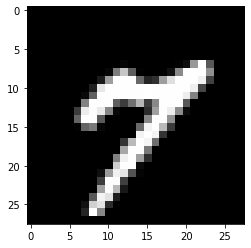

In [15]:
#challenge, show one image of a number
train_set[0][0].shape   #train_set[0] is the image, label, so [0][0] is the imge

#hint: plt.imshow
plt.imshow(train_set[0][0].reshape(28,28), cmap="gray")

#what is the label of this guy?
train_set[0][1]

## 2. Create dataloaders

In [16]:
#train batch_size = 10
#val batch_size = everything
#test batch_size = everything
#all shuffle = True

#format: DataLoader(dataset, batch_size, shuffle)

train_loader = DataLoader(train_set, batch_size=10,            shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=len(val_set),  shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=len(test_set), shuffle=True)


## 3. Test the dataloader

In [18]:
#run a for loop train_loader and then break, and then print out shape of image, label
for images, label in train_loader:
    print(images.shape)
    print(label.shape)
    break

#what is [10, 1, 28, 28]
#        [batch_size, c, w, h] = image
#what is [10]
#        [batch_size] = target


torch.Size([10, 1, 28, 28])
torch.Size([10])


## 3. Learn about nn.Conv2d

In [19]:
#format: nn.Conv2d(input_channel, output_channel, kernel_size, stride=1, padding=0)
#if i know my image is channel 1
#let's say I want to convert this channel 1 to 13, 
#kernel_size = 3
#stride = 1
#padding = 0
chaky_layer = nn.Conv2d(1, 13, 3, 1, 0)

In [20]:
chaky_layer

Conv2d(1, 13, kernel_size=(3, 3), stride=(1, 1))

In [25]:
# chaky_layer.weight.shape

In [26]:
# chaky_layer.bias.shape

In [27]:
#can you take image for me
image = train_set[0][0]
image.shape

torch.Size([1, 28, 28])

In [31]:
out = chaky_layer(image)
out.shape
#where does [13, 26, 26] comes from???
#(input_size - k + 2P) / s +1
# (28 - 3 + 2*0) / 1 + 1

torch.Size([13, 26, 26])

In [32]:
#can you create another convolution layer
#that can accept this input [13, 26, 26]
#kernel size =3, stride =1, padding = 0, output_channel = 5, input_channel = ???
chaky_layer2 = nn.Conv2d(13,5,3,1,0)
out2 = chaky_layer2(out)
print(out2.shape)
#what is [5, 24, 24]
#5 is the output_channel
#24 - do the math by yourself

torch.Size([5, 24, 24])


In [34]:
image.shape

torch.Size([1, 28, 28])

torch.Size([128, 20, 20])


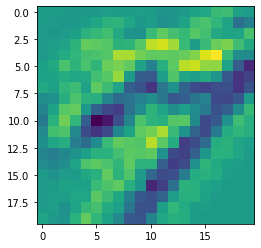

In [39]:
#create two convolutional layer
#of outputchannel 256, then 128
#kernel_size = 5, stride = 1, padding = 0
layers = nn.Sequential(nn.Conv2d(1,256,5,1,0),nn.Conv2d(256,128,5,1,0))
out3 = layers(image)
print(out3.shape)
plt.imshow(out3[0].detach().numpy())

## 4. Learn about maxpool2d

In [40]:
pool = nn.MaxPool2d(2, 2)

In [42]:
image.shape

torch.Size([1, 28, 28])

In [44]:
out = pool(image)
out.shape

torch.Size([1, 14, 14])

In [45]:
#let's have break until 17:15